## Imports

For this project we use the pandas, geopandas, and matplotlib modules

In [49]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

## Crime Dataset

From [data.boston.gov](https://data.boston.gov/dataset/crime-incident-reports-august-2015-to-date-source-new-system), we downloaded and read in the individual CSV for the crime incident reports from years 2015-2018. 2012-2015 is also available, but the system for the offense codes of crimes changed after this data was collected. We decided not to waste effort translating the old codes to the new codes, especially since the older data contained only about 10% of the records that the new data has.

We appended all the individual files from each year into one DataFrame, then selected the columns of interest. Namely, OFFENSE_CODE, OFFENSE_DESCRIPTION, YEAR, and Lat/Long.

In [50]:
crime_2015 = pd.read_csv('data/crime-incident-reports-2015.csv')
crime_2016 = pd.read_csv('data/crime-incident-reports-2015.csv')
crime_2017 = pd.read_csv('data/crime-incident-reports-2017.csv')
crime_2018 = pd.read_csv('data/crime-incident-reports-2018.csv')

In [51]:
crime = pd.DataFrame()
crime=crime.append(crime_2015, ignore_index=True)
crime=crime.append(crime_2016, ignore_index=True)
crime=crime.append(crime_2017, ignore_index=True)
crime=crime.append(crime_2018, ignore_index=True)
crime=crime[['OFFENSE_CODE', 'OFFENSE_DESCRIPTION', 'YEAR', 'Lat', 'Long']]

## Liquor Licenses Dataset

Again from [data.boston.gov](https://data.boston.gov/dataset/liquor-licenses), we downloaded and read the CSV containing info about liquor licenses in Boston. We select only the license ID, the issuing date, the type of license, the status of the license ('Active', etc.), the establishment name, and the GPSX and GPSY coordinates.

In [52]:
alc = pd.read_csv('data/blb_section_12_alcohol.csv')
alc=alc[['license_num', 'issued', 'license_type', 'status', 'dba_name', 'gpsx', 'gpsy']]

## Colleges Dataset

We read in the colleges from the CSV, and filter only the name of the college as well as the Lat/Long

In [53]:
colleges = pd.read_csv('data/Colleges_and_Universities.csv')
colleges = colleges[['Name', 'Latitude', 'Longitude']]

## Neighborhood GeoJSON File

We imported the geoJSON file for Boston neighborhoods that we downloaded from data.boston.gov. We also cast the Neighborhood_ID field from and Object to an int.

We chose to use neighborhood-level analysis as opposed to tract level because after observing our filtered data (seen below), we realized that the amount of either bars or crimes for many census tracts was too low. We wanted to show more significant variation between larger areas of Boston.

In [54]:
nb = gpd.read_file("data/Boston_Neighborhoods.geojson")
nb = nb.astype({'Neighborhood_ID': 'int64'})
# nb

### Filtering the crime data

We only want to look at crimes that are explicitly related to alcohol. The offense codes that we used were 2201, 2101, and 2646, which are respectively 'Liquor - Involving Minors', 'Operating Under the Influence of Alcohol', and 'Liquor - Drinking in Public'.

We them removed any rows that had a null value for either Lat or Long.

In [55]:
off_codes = [2201, 2101, 2646]
crime = crime.loc[crime['OFFENSE_CODE'].isin(off_codes)]
crime = crime[crime[['Lat', 'Long']].notnull().all(1)]

### Filtering liquor licenses data

We wanted to focus specifically on bars or similar establishments where patrons would engage in drinking at the establishment as opposed to just purchasing the alcohol for later use. There are many types of liquor licenses, but we found that in order to remove places such as gas stations or liquor stores and only focus on sit-down restaurants and bars, we could efficiently select only those rows where the license type contained the string 'All Alc.'

In [56]:
alc = alc.loc[alc['license_type'].str.contains('All Alc.')]

## Spatial Joins

The next four code cells are dedicated to converting the Lat/Long columns from each dataset into a Neighborhood_ID that will be used for aggregation and mapping.

In [57]:
crime_gdf = gpd.GeoDataFrame(crime, geometry=gpd.points_from_xy(crime.Long, crime.Lat))
crime_gdf = crime_gdf.set_crs("EPSG:4326")
crime_gdf = gpd.sjoin(crime_gdf, nb[['Neighborhood_ID', 'Name', 'geometry']], how='left')
crime = pd.DataFrame(crime_gdf.drop(columns=['geometry', 'index_right']))
crime
# crime.dropna(subset = ['Neighborhood_ID'])
crime = crime[crime['Neighborhood_ID'].notna()]
crime = crime.astype({'Neighborhood_ID': 'int64'})
# crime

In [58]:
college_gdf = gpd.GeoDataFrame(colleges, geometry=gpd.points_from_xy(colleges.Longitude, colleges.Latitude))
college_gdf = college_gdf.set_crs("EPSG:4326")
college_gdf = gpd.sjoin(college_gdf, nb[['Neighborhood_ID', 'Name', 'geometry']], how='left')
colleges = pd.DataFrame(college_gdf.drop(columns=['geometry', 'index_right']))
colleges = colleges[colleges[['Neighborhood_ID']].notnull().all(1)]
colleges = colleges.astype({'Neighborhood_ID': 'int64'})
colleges = colleges[colleges.Neighborhood_ID != 28]

#### Note on Liquor Licenses Dataset

The coords for the liquor dataset are in SPC form, and must be converted to Lat/Long. This was done using [an online tool](https://geodesy.noaa.gov/NCAT/). Instead of having null values, the initial coords were set to 0. When converted to Lat/Long, the value was under 35 (nowhere near Boston). We filtered out any rows with Lat/Long under 35.

In [59]:
alc_latlong = pd.read_csv('data/alc_coords.csv')
alc_latlong = alc_latlong.rename(columns={"ID":"license_num"})
alc_latlong
alc = pd.merge(alc, alc_latlong, on="license_num")
alc=alc[['license_type', 'license_num', 'status', 'dba_name', 'srcLat', 'srcLon']]
alc = alc[alc[['srcLat', 'srcLon']].notnull().all(1)]
alc = alc.loc[alc['srcLat'] > 35.0]

In [60]:
alc_gdf =gpd.GeoDataFrame(alc, geometry=gpd.points_from_xy(alc.srcLon, alc.srcLat))
alc_gdf = alc_gdf.set_crs("EPSG:4326")
alc_gdf = gpd.sjoin(alc_gdf, nb[['Neighborhood_ID', 'Name', 'geometry']], how='left')
alc = pd.DataFrame(alc_gdf.drop(columns=['geometry', 'index_right']))
alc = alc[alc[['Neighborhood_ID']].notnull().all(1)]
alc = alc.astype({'Neighborhood_ID': 'int64'})

In [61]:
# crime.Neighborhood_ID.unique()

In [62]:
# crime.loc[crime['Neighborhood_ID'] == 28]

In [63]:
# colleges

### Aggregating

Now, we group the datasets by neighborhood with a count method.

In [64]:
bar_count = alc.groupby(by=['Neighborhood_ID']).count()['license_num']
bar_count = bar_count.rename('bar_count')
# bar_count

Note: crime_count is not counting offenses from outside of Boston

In [65]:
crime_count = crime.groupby(by=['Neighborhood_ID']).count()['OFFENSE_CODE']
crime_count = crime_count.rename('crime_count')
# crime_count

... and merge them into one dataset.

In [66]:
cols = {'crime':crime_count}
crime_df = pd.DataFrame(cols)

cols1 = {'bars':bar_count}
bars_df = pd.DataFrame(cols1)
bars_df = bars_df.drop(28)
# bars_df

combined_df = crime_df.join(bars_df, how='inner', sort=False)
combined_df

# Visualization

From here, we just need to translate this data into maps for clear visualization.

We have a map each for the crimes and bars datasets, and on both maps we overlay the locations of colleges in Boston as red dots.

In [67]:
college_geo = gpd.points_from_xy(colleges.Longitude, colleges.Latitude)
c_geo_df = gpd.GeoDataFrame(geometry = college_geo)

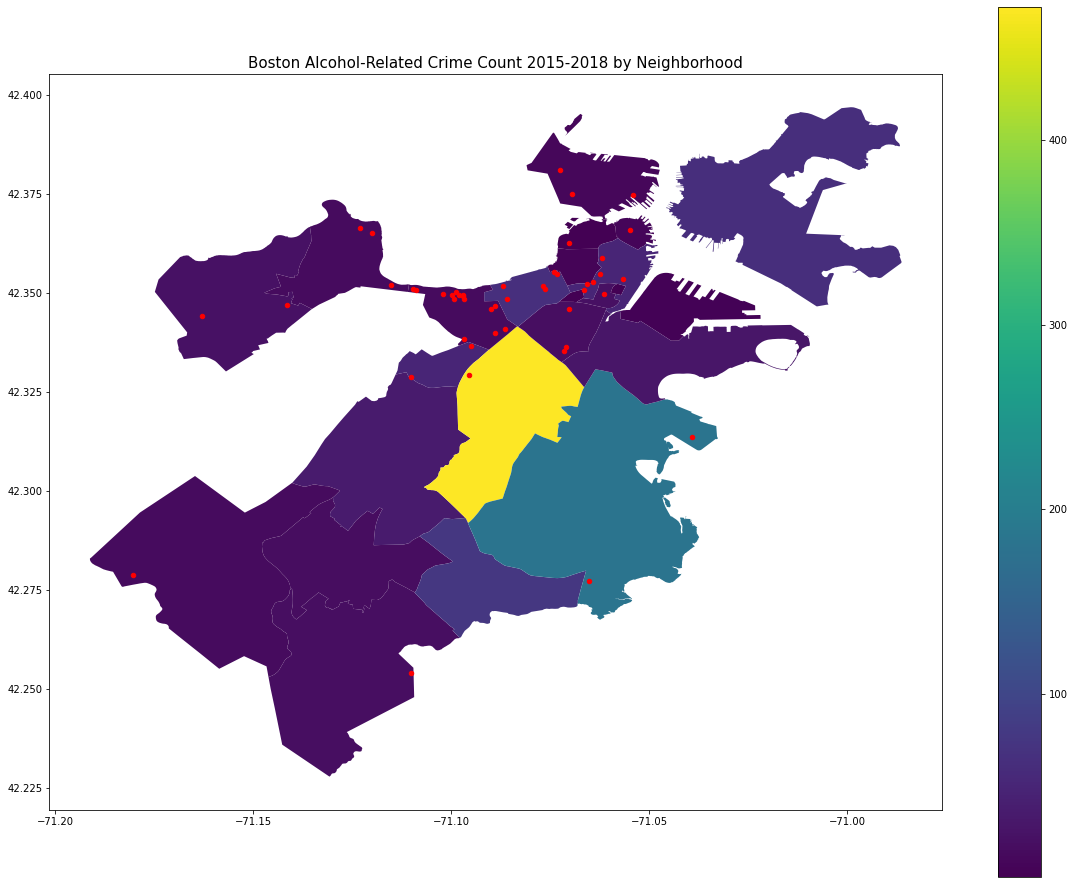

In [68]:
fig,ax = plt.subplots(figsize = (20,16))
crime_map = pd.merge(nb, combined_df, on="Neighborhood_ID")
crime_map.plot(ax = ax, column = 'crime', legend=True, figsize=(20,16))
g = c_geo_df.plot(ax=ax, markersize = 20, color = 'red')
plt.title('Boston Alcohol-Related Crime Count 2015-2018 by Neighborhood', fontsize = 15)
plt.show()

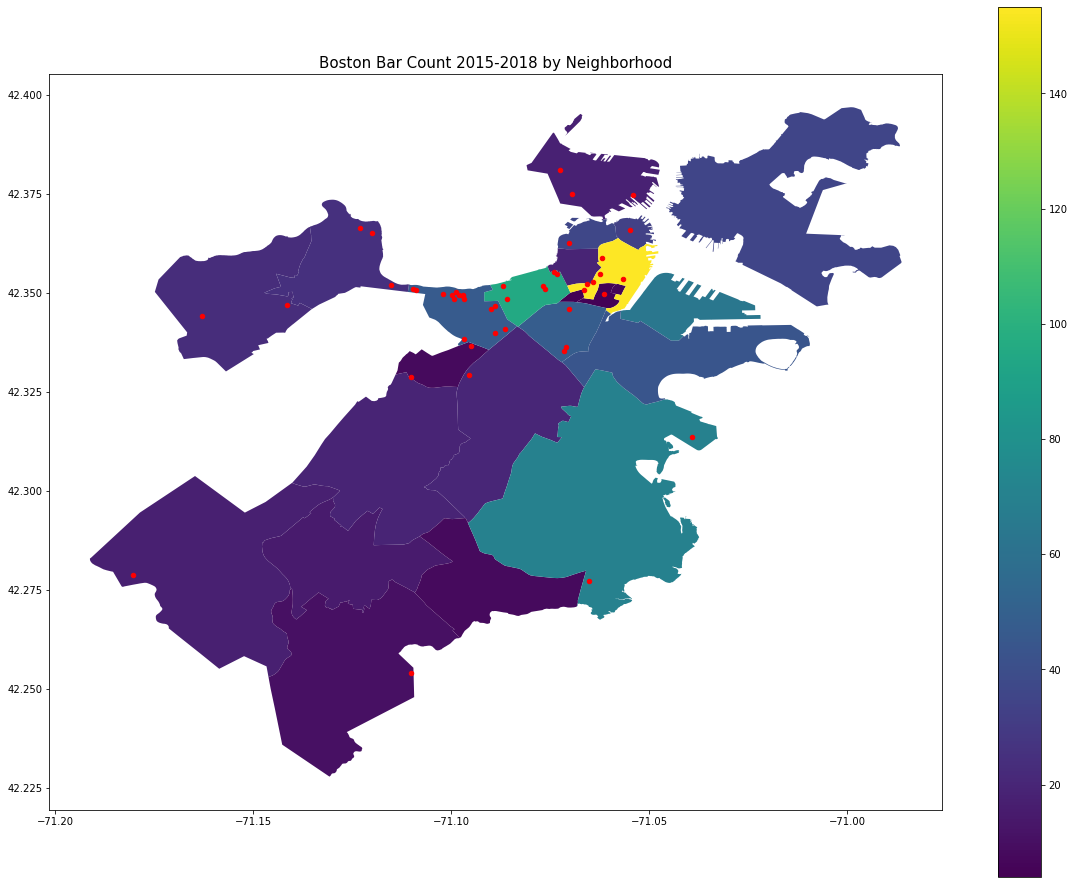

In [69]:
fig,ax = plt.subplots(figsize = (20,16))
bar_map = pd.merge(nb, combined_df, on="Neighborhood_ID")
bar_map.plot(ax=ax, column = 'bars', legend=True, figsize=(20,16))
g = c_geo_df.plot(ax=ax, markersize = 20, color = 'red')
plt.title('Boston Bar Count 2015-2018 by Neighborhood', fontsize = 15)
plt.show()